/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 1: Reward = -500.0
Episode 2: Reward = -500.0
Episode 3: Reward = -500.0
Episode 4: Reward = -416.0
Episode 5: Reward = -500.0
Episode 6: Reward = -414.0
Episode 7: Reward = -500.0
Episode 8: Reward = -319.0
Episode 9: Reward = -425.0
Episode 10: Reward = -500.0
Episode 11: Reward = -500.0
Episode 12: Reward = -500.0
Episode 13: Reward = -398.0
Episode 14: Reward = -500.0
Episode 15: Reward = -230.0
Episode 16: Reward = -500.0
Episode 17: Reward = -500.0
Episode 18: Reward = -463.0
Episode 19: Reward = -412.0
Episode 20: Reward = -316.0
Episode 21: Reward = -491.0
Episode 22: Reward = -477.0
Episode 23: Reward = -500.0
Episode 24: Reward = -500.0
Episode 25: Reward = -287.0
Episode 26: Reward = -500.0
Episode 27: Reward = -152.0
Episode 28: Reward = -444.0
Episode 29: Reward = -292.0
Episode 30: Reward = -282.0
Episode 31: Reward = -218.0
Episode 32: Reward = -379.0
Episode 33: Reward = -152.0
Episode 34: Reward = -232.0
Episode 35: Reward = -236.0
Episode 36: Reward = -318.0
E

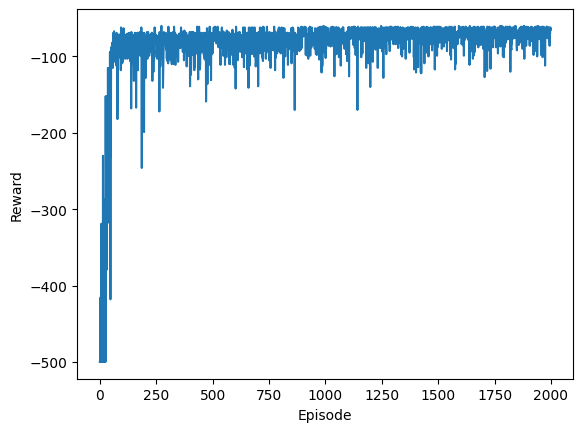

Test Episode 1: Reward = -60.59999999999991
Test Episode 2: Reward = -52.59999999999994
Test Episode 3: Reward = -53.399999999999935
Test Episode 4: Reward = -53.399999999999935
Test Episode 5: Reward = -58.999999999999915
Test Episode 6: Reward = -49.39999999999995
Test Episode 7: Reward = -52.59999999999994
Test Episode 8: Reward = -48.59999999999995
Test Episode 9: Reward = -54.19999999999993
Test Episode 10: Reward = -59.79999999999991
Test Episode 11: Reward = -49.39999999999995
Test Episode 12: Reward = -53.399999999999935
Test Episode 13: Reward = -53.399999999999935
Test Episode 14: Reward = -48.59999999999995
Test Episode 15: Reward = -54.19999999999993
Test Episode 16: Reward = -54.19999999999993
Test Episode 17: Reward = -54.19999999999993
Test Episode 18: Reward = -73.39999999999986
Test Episode 19: Reward = -59.79999999999991
Test Episode 20: Reward = -52.59999999999994
Test Episode 21: Reward = -54.19999999999993
Test Episode 22: Reward = -54.19999999999993
Test Episode 2

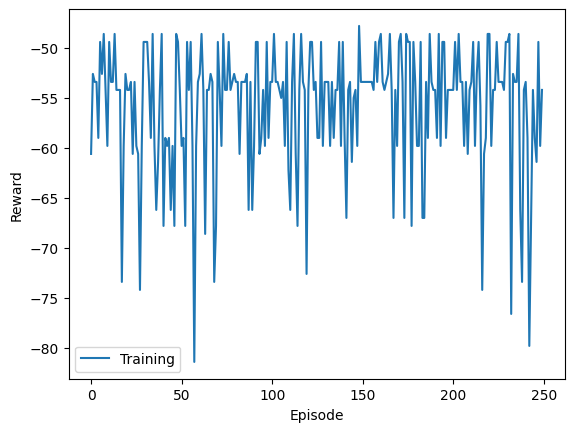

In [ ]:

import random
import math
from collections import deque
from itertools import count

import gym
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np


#Here we are defining the DQN Class
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 64)
        self.fc6 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        return self.fc6(x)


# we choose the hyperparameters here
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 0.001
LR = 0.001
TARGET_UPDATE = 5 # Update the target network every 10 episodes
TARGET_UPDATE_WEIGHT = 0.05  # Weight parameter for soft target network update

# Seting up the environment and device
env = gym.make("Acrobot-v1")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Geting number of actions and observations
n_actions = env.action_space.n
n_observations = env.observation_space.shape[0]

# Initializing the policy and target networks
policy_net = DQN(n_observations, n_actions).to(device)

target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()  # Set the target network to evaluation mode

# Seting up the optimizer and replay memory
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = deque(maxlen=100000)

steps_done = 0

# Here we write the function  to select actions using epsilon-greedy exploration
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1.0 * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

#Here we write the function to test the trained model
def test_agent(policy_net, num_test_episodes):
    test_rewards = []
    exploration_bonus = 0.2

    for episode in range(num_test_episodes):
        state = env.reset()
        state = torch.tensor(state, device=device, dtype=torch.float).unsqueeze(0)
        episode_reward = 0
        has_visited = set()

        while True:
            with torch.no_grad():
                action = policy_net(state).max(1)[1].view(1, 1)

            next_state, reward, done, _ = env.step(action.item())
            next_state = torch.tensor(next_state, device=device, dtype=torch.float).unsqueeze(0)

            # Add exploration bonus
            if next_state[0] not in has_visited:
                reward += exploration_bonus
                has_visited.add(next_state[0])

            episode_reward += reward

            if done:
                break

            state = next_state

        test_rewards.append(episode_reward)
        print(f"Test Episode {episode + 1}: Reward = {episode_reward}")

    return test_rewards


# we train the model for 2000 episodes if we have GPU or 1000 if We have cpu
if torch.cuda.is_available():
    num_episodes = 2000
else:
    num_episodes = 1000
episode_durations = []
episode_rewards = []

for episode in range(num_episodes):
    state = env.reset()
    state = torch.tensor(state, device=device, dtype=torch.float).unsqueeze(0)

    total_reward = 0

    for t in count():
        # we are selecting and performing an action
        action = select_action(state)
        next_state, reward, done, _ = env.step(action.item())
        next_state = torch.tensor(next_state, device=device, dtype=torch.float).unsqueeze(0)

        # Updating the total reward for this episode
        total_reward += reward

        # Storing the transition in memory
        memory.append((state, action, next_state, reward, done))

        # Moving to the next state
        state = next_state

        # Performing one step of the optimization (on the policy network)
        if len(memory) >= BATCH_SIZE:
            transitions = random.sample(memory, BATCH_SIZE)
            batch = list(zip(*transitions))

            state_batch = torch.cat(batch[0])
            action_batch = torch.cat(batch[1])
            next_state_batch = torch.cat(batch[2])
            reward_batch = torch.tensor(batch[3], device=device, dtype=torch.float).unsqueeze(1)
            done_batch = torch.tensor(batch[4], device=device, dtype=torch.bool).unsqueeze(1)

            # Computing the expected Q-values
            current_q_values = policy_net(state_batch).gather(1, action_batch)
            next_q_values = target_net(next_state_batch).max(1, keepdim=True)[0]
            target_q_values = reward_batch + (GAMMA * next_q_values) * (~done_batch)

            # Computing the loss and optimize the model
            loss = nn.functional.mse_loss(current_q_values, target_q_values.detach())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Updating the target network using a soft update
            if episode % TARGET_UPDATE == 0:
                for target_param, policy_param in zip(target_net.parameters(), policy_net.parameters()):
                    target_param.data.copy_(TARGET_UPDATE_WEIGHT * policy_param.data + (1 - TARGET_UPDATE_WEIGHT) * target_param.data)

        # when we are done
        if done:
            episode_durations.append(t + 1)
            episode_rewards.append(total_reward)

            break

env.close()

for i, reward in enumerate(episode_rewards):
    print(f"Episode {i + 1}: Reward = {reward}")

average_train = sum(episode_rewards) / len(episode_rewards)
print(f"Average train reward over {num_episodes} episodes: {average_train}")


# Ploting the episode rewards
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()




# Testing the trained policy network
num_test_episodes = 250
test_rewards = test_agent(policy_net, num_test_episodes)
avg_test_reward = sum(test_rewards) / len(test_rewards)
print(f"Average test reward over {num_test_episodes} episodes: {avg_test_reward}")

#ploting the test rewards
plt.plot(test_rewards)
plt.legend(['Training', 'Testing'])
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()